## Showcasing larger range of highly activating images

Note: We're not using a fixed random seed so images will be different from the ones in paper

In [1]:
import os
#virtually move to parent directory
os.chdir("..")

import torch
import matplotlib
from matplotlib import pyplot as plt

import utils
import data_utils
import similarity

## Settings

In [2]:
figure = 'fig13b'

settings = {'fig12a': {"target_name":'resnet18_places', "target_layer": 'layer1'}, 
            'fig12b': {"target_name":'resnet18_places', "target_layer": 'layer4'},
            'fig13a': {"target_name":'resnet50', "target_layer": 'layer1'}, 
            'fig13b': {"target_name":'resnet50', "target_layer": 'layer4'},
           }

target_name = settings[figure]['target_name']
target_layer = settings[figure]['target_layer']
            
clip_name = 'ViT-B/16'
d_probe = 'imagenet_broden'
concept_set = 'data/20k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

## Run CLIP-Dissect

In [3]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

In [4]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                                text_save_name, similarity_fn, device=device)

100%|██████████| 2048/2048 [00:11<00:00, 172.97it/s]


torch.Size([2048, 20000])


First row: 5 most highly activating images

Second row: random sample from top 0.1% most highly activating images

Third row: random sample from top 1% most highly activating images

Fourth row: random sample from top 5% most highly activating images## Visualize

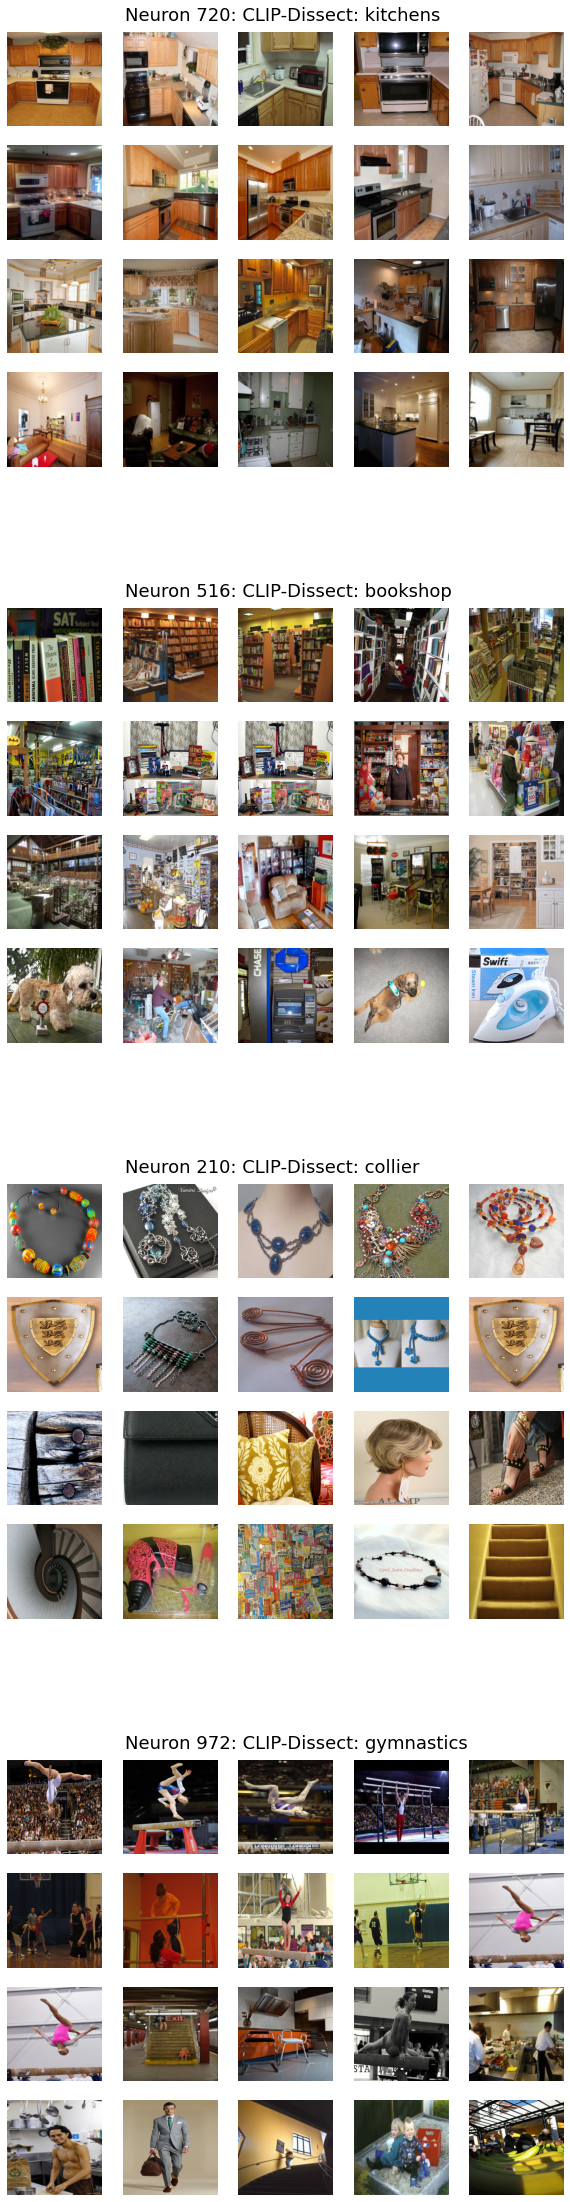

In [5]:
top_ids_dict = {}
top_ids_dict["top5"] = torch.topk(target_feats, k=5, dim=0)[1]

for fraction in [0.001, 0.01, 0.05]:
    top_k = int(fraction*len(target_feats))
    top_vals, top_ids = torch.topk(target_feats, k=top_k, dim=0)
    indices = torch.randint(high=len(top_ids), size=(5,target_feats.shape[1]))
    top_ids_dict["{:.1f}".format(fraction*100)] = top_ids.gather(0, indices)

neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:4]

font_size=18
font = {'size'   : font_size}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*8])
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)

for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
        
    subfig = subfigs[j]
    subfig.text(0.29, 0.9, "Neuron {}: CLIP-Dissect: {}".format(int(orig_id), words[int(ids[0])]), size=font_size)
    axs = subfig.subplots(nrows=4, ncols=5)
    for j, key in enumerate(top_ids_dict):
        top_ids = top_ids_dict[key]
        for i, top_id in enumerate(top_ids[:, orig_id]):
            im, label = pil_data[top_id]
            im = im.resize([375,375])
            axs[j, i].imshow(im)
            axs[j, i].axis('off')
    #fig.tight_layout()
plt.show()